# 12 - Estimação Duplamente Robusta

## Não Coloque Todos os Ovos na Mesma Cesta

Aprendemos como utilizar a regressão linear e o peso da pontuação de propensão para estimar $E[Y|T=1] - E[Y|T=0] | X$. Mas qual devemos usar e quando? Em caso de dúvida, use ambos! A Estimação Duplamente Robusta é uma maneira de combinar a pontuação de propensão e a regressão linear de forma que você não precise depender exclusivamente de uma delas.

Para entender como isso funciona, vamos considerar o experimento da mentalidade. Trata-se de um estudo randomizado realizado em escolas públicas dos Estados Unidos, com o objetivo de avaliar o impacto da mentalidade de crescimento. O procedimento consiste em fornecer aos alunos um seminário, promovido pela escola, para fomentar uma mentalidade de crescimento. Em seguida, eles acompanham os alunos durante seus anos universitários para medir seu desempenho acadêmico. Essa medição é compilada em uma pontuação de realização e padronizada. Os dados reais deste estudo não estão disponíveis publicamente para preservar a privacidade dos alunos. No entanto, temos um conjunto de dados simulado com as mesmas propriedades estatísticas fornecidas por [Athey and Wager](https://arxiv.org/pdf/1902.07409.pdf), e usaremos esse conjunto simulado no lugar.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Embora o estudo tenha sido randomizado, parece que os dados não estão livres de confundidores. Uma possível razão é que a variável de tratamento é medida pela participação do aluno no seminário. Assim, embora a oportunidade de participação tenha sido aleatória, a participação em si não o foi. Estamos lidando com um caso de cumprimento parcial aqui. Uma evidência disso é como a expectativa de sucesso do aluno está correlacionada com a participação no seminário. Alunos com expectativas auto-relatadas mais altas têm maior probabilidade de terem participado do seminário sobre mentalidade de crescimento.

In [3]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Como sabemos agora, podemos ajustar isso usando uma regressão linear ou estimando um modelo de pontuação de propensão com uma regressão logística. Antes de fazer isso, no entanto, precisamos converter as variáveis categóricas em variáveis dummy.

In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


Estamos agora prontos para compreender como funciona a estimação duplamente robusta.

## Estimação Duplamente Robusta

![img](./data/img/doubly-robust/double.png)

Em vez de derivar o estimador, vou primeiro mostrá-lo e só então explicar por que é incrível.

$
\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)
$

onde $\hat{P}(x)$ é uma estimativa da pontuação de propensão (usando regressão logística, por exemplo), $\hat{\mu_1}(x)$ é uma estimativa de $E[Y|X, T=1]$ (usando regressão linear, por exemplo), e $\hat{\mu_0}(x)$ é uma estimativa de $E[Y|X, T=0]$. Como você já deve ter imaginado, a primeira parte do estimador duplamente robusto estima $E[Y_1]$ e a segunda parte estima $E[Y_0]$. Vamos examinar a primeira parte, pois toda a intuição também se aplicará à segunda parte por analogia.

Como sei que esta fórmula pode parecer assustadora à primeira vista (mas não se preocupe, verá que é super simples), vou primeiro mostrar como codificar este estimador. Tenho a sensação de que algumas pessoas se assustam menos com código do que com fórmulas. Vamos ver como este estimador funciona na prática, certo?

In [5]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [6]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.38822121767832457

O estimador duplamente robusto está indicando que devemos esperar que os indivíduos que participaram do seminário sobre mentalidade estejam 0.388 desvios padrão acima de seus colegas não tratados, em termos de realizações. Mais uma vez, podemos utilizar a técnica de amostras com reposição *(bootstrap, em inglês)* para construir intervalos de confiança.

In [7]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [8]:
print(f"ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

ATE 95% CI: (0.35364752721776144, 0.41978441342477585)


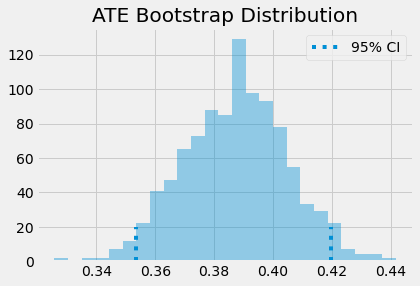

In [9]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

Agora que tivemos uma ideia do estimador duplamente robusto, vamos examinar por que ele é tão bom. Primeiro, é chamado de duplamente robusto porque só exige que um dos modelos, $\hat{P}(x)$ ou $\hat{\mu}(x)$, esteja corretamente especificado. Para entender isso, pegue a primeira parte que estima $E[Y_1]$ e analise-a cuidadosamente.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

Suponha que $\hat{\mu_1}(x)$ seja correto. Se o modelo de pontuação de propensão estiver errado, não precisamos nos preocupar. Isso porque, se $\hat{\mu_1}(x)$ estiver correto, então $E[T_i(Y_i - \hat{\mu_1}(X_i))]=0$. Isso ocorre porque a multiplicação por $T_i$ seleciona apenas os tratados, e o resíduo de $\hat{\mu_1}$ nos tratados tem, por definição, média zero. Isso faz com que o conjunto inteiro se reduza a $\hat{\mu_1}(X_i)$, que é a estimativa correta de $E[Y_1]$ por hipótese. Portanto, você vê que, ao estar correto, $\hat{\mu_1}(X_i)$ elimina a relevância do modelo de escore de propensão. Podemos aplicar o mesmo raciocínio para compreender o estimador de $E[Y_0]$.

Mas não confie apenas em minhas palavras. Deixe o código mostrar o caminho! No estimador a seguir, substituí a regressão logística que estima o escore de propensão por uma variável aleatória uniforme que varia de 0.1 a 0.9 (não quero pesos muito pequenos aumentando a variância do escore de propensão). Como isso é aleatório, não tem esse modelo ser um bom modelo de escore de propensão, mas veremos que o estimador duplamente robusto ainda consegue produzir uma estimativa muito próxima daquela obtida quando o escore de propensão foi estimado com regressão logística.

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [11]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.3797369830995927

Se utilizarmos a técnica de amostras com reposição, podemos observar que a variância é ligeiramente maior do que quando o escore de propensão foi estimado com regressão logística.

In [12]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_ps)
wrong_ps = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                              for _ in range(bootstrap_sample))
wrong_ps = np.array(wrong_ps)

In [13]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))

print(f"Wrong PS ATE 95% CI:", (np.percentile(wrong_ps, 2.5), np.percentile(wrong_ps, 97.5)))

Original ATE 95% CI: (0.35364752721776144, 0.41978441342477585)
Wrong PS ATE 95% CI: (0.33806443306747086, 0.4335673822553228)


Como podemos ver, comprometer a pontuação de propensão gera ATEs ligeiramente diferentes, mas não muito. Isso abrange o caso em que o modelo de propensão está errado, mas o modelo de resultado está correto. E quanto à outra situação? Vamos mais uma vez analisar cuidadosamente a primeira parte do estimador, mas vamos rearranjar alguns termos.

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)
$

$
\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)
$

Agora, suponha que o escore de propensão $\hat{P}(X_i)$ esteja corretamente especificado. Nesse caso, $E[T_i - \hat{P}(X_i)]=0$, o que elimina a parte dependente de $\hat{\mu_1}(X_i)$. Isso faz com que o estimador duplamente robusto se reduza ao estimador de ponderação pelo escore de propensão $\frac{T_iY_i}{\hat{P}(X_i)}$, que é correto por hipótese. Portanto, mesmo que $\hat{\mu_1}(X_i)$ esteja incorreto, o estimador ainda será correto, desde que o escore de propensão esteja corretamente especificado.

Mais uma vez, se você confia mais em código do que em fórmulas, aqui está a verificação prática. No código abaixo, substituí ambos os modelos de regressão por uma variável normal aleatória. Não há dúvida de que $\hat{\mu}(X_i)$ **não está corretamente especificado**. Ainda assim, veremos que a estimação duplamente robusta ainda consegue recuperar o mesmo $\hat{ATE}$ de cerca de 0.38 que vimos antes.

In [14]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [15]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.39811864040982625

Mais uma vez, podemos usar a técnica de amostras com reposição e observar que a variância é apenas ligeiramente maior.

In [16]:
np.random.seed(88)
parallel_fn = delayed(doubly_robust_wrong_model)
wrong_mux = Parallel(n_jobs=4)(parallel_fn(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                               for _ in range(bootstrap_sample))
wrong_mux = np.array(wrong_mux)

In [17]:
print(f"Original ATE 95% CI:", (np.percentile(ates, 2.5), np.percentile(ates, 97.5)))
print(f"Wrong Mu ATE 95% CI:", (np.percentile(wrong_mux, 2.5), np.percentile(wrong_mux, 97.5)))

Original ATE 95% CI: (0.35364752721776144, 0.41978441342477585)
Wrong Mu ATE 95% CI: (0.33863822614929406, 0.433173164584189)


Mais uma vez, alterar apenas o modelo da média condicional gera apenas uma ATE ligeiramente diferente. Espero tê-lo convencido sobre o poder da estimação duplamente robusta. Sua magia acontece porque, na inferência causal, há duas maneiras de remover o viés de nossas estimativas causais: ou modelamos o mecanismo de tratamento ou o mecanismo de resultado. Se um desses modelos estiver correto, você está pronto para prosseguir.

Uma ressalva é que, na prática, é muito difícil modelar precisamente qualquer um deles. Frequentemente, o que acaba acontecendo é que nem o escore de propensão nem o modelo de resultado são 100% corretos. Ambos estão errados, mas de maneiras diferentes. Quando isso acontece, ainda não está exatamente definido [\[1\]](https://www.stat.cmu.edu/~ryantibs/journalclub/kang_2007.pdf) [\[2\]](https://arxiv.org/pdf/0804.2969.pdf) [\[3\]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2798744/) se é melhor usar um único modelo ou a estimação duplamente robusta. Quanto a mim, ainda gosto de usá-los porque, pelo menos, me dá duas possibilidades de estar correto.


## Conceitos-chave

Aqui, vimos uma maneira simples de combinar a regressão linear com a pontuação de propensão para produzir um estimador duplamente robusto. Este estimador recebe esse nome porque requer apenas que um dos modelos esteja correto. Se o modelo de escore de propensão estiver correto, poderemos identificar o efeito causal mesmo que o modelo de resultado esteja errado. Por outro lado, se o modelo de resultado estiver correto, também poderemos identificar o efeito causal mesmo que o modelo de escore de propensão esteja errado.

## Referências

Gosto de pensar nesta série inteira como uma homenagem a Joshua Angrist, Alberto Abadie e Christopher Walters por sua incrível aula de Econometria. A maioria das ideias aqui foram tiradas de suas aulas na *American Economic Association*. Assisti-las é o que está me mantendo são durante este difícil ano de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Também gostaria de referenciar os livros incríveis de Angrist. Eles me mostraram que Econometria, ou 'Métricas, como eles chamam, não é apenas extremamente útil, mas também profundamente divertida.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Finalmente, gostaria de referenciar o livro de Miguel Hernan e Jamie Robins. Tem sido meu fiel companheiro nas questões mais espinhosas de inferência causal que tive que responder.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Os dados que utilizamos foram retirados do artigo [Estimating Treatment Effects with Causal Forests: An Application](https://arxiv.org/pdf/1902.07409.pdf), de Susan Athey e Stefan Wager.

![img](./data/img/poetry.png)

## Contribua

"Inferência Causal para os Corajosos e Verdadeiros" é um material de código aberto sobre inferência causal, a estatística da ciência. Seu objetivo é ser acessível monetariamente e intelectualmente. Ele utiliza apenas software gratuito baseado em Python.
Se você encontrou valor neste livro e deseja apoiá-lo, por favor, vá para o [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Se você não estiver pronto para contribuir financeiramente, também pode ajudar corrigindo erros, sugerindo edições ou dando feedback sobre trechos que não compreendeu. Acesse o repositório do livro e abra uma issue na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/issues) ou na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/issues). Por fim, se você gostou deste conteúdo, compartilhe com outras pessoas que possam achar útil e dê uma estrela no GitHub na [versão em inglês](https://github.com/matheusfacure/python-causality-handbook/stargazers) e na [versão em português](https://github.com/rdemarqui/python-causality-handbook-ptbr/stargazers).

---

<div align="center">
<a href="11-Propensity-Score.ipynb"><-- Anterior</a>  
<a href="00-Summary.ipynb">| Sumário |</a>  
<a href="13-Difference-in-Differences.ipynb">Próximo --></a>  

<a href="https://matheusfacure.github.io/python-causality-handbook/12-Doubly-Robust-Estimation.html">[12 - Doubly Robust Estimation]</a>  

</div>